In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
from pyquaternion import Quaternion
import re

In [2]:
def getFirstNonNanTimestamp(dataframe):
    non_nan_entry_prediction = np.where(~np.isnan(dataframe['x_pos'].to_numpy()))[0]
    return dataframe['Timestamp'][non_nan_entry_prediction[0]], non_nan_entry_prediction[0]

In [3]:
def getTimestampIndex(dataframe, timestamp):
    return np.where(dataframe['Timestamp'] == timestamp)[0][0]

In [57]:
def scoreTrajectory(gt_traj, estimated_traj, plot = False):
    first_ts_gt, gt_idx = getFirstNonNanTimestamp(gt_traj)
    first_ts_est, est_idx = getFirstNonNanTimestamp(estimated_traj)
    
    if first_ts_gt > first_ts_est:
        est_idx = getTimestampIndex(estimated_traj, first_ts_gt)
    else:
        gt_idx = getTimestampIndex(gt_traj, first_ts_est)
    
    gt_traj = gt_traj.iloc[gt_idx:,:]
    estimated_traj = estimated_traj.iloc[est_idx:,:]
    
    length = min(len(gt_traj), len(estimated_traj))
    gt_traj = gt_traj.iloc[:length,:]
    estimated_traj = estimated_traj.iloc[:length,:]
    
    print("found ", length, "Timestamps")
    non_nan = np.logical_and(~np.isnan(gt_traj['x']) ,~np.isnan(estimated_traj['x']))
    non_nan = non_nan[non_nan == non_nan]
    estimated_traj = estimated_traj.iloc[np.where(non_nan)[0],:]
    gt_traj = gt_traj.iloc[np.where(non_nan)[0],:]
    
    
    gt_pos = gt_traj[['x_pos', 'y_pos', 'z_pos']].to_numpy()
    est_pos = estimated_traj[['x_pos', 'y_pos', 'z_pos']].to_numpy()
    
    gt_rot =  gt_traj[['x', 'y', 'z','w']].to_numpy()
    est_rot =  estimated_traj[['x', 'y', 'z','w']].to_numpy()
    
    
    
    
    p = re.compile("[^-'](-?\d\.\d*)")
    
    if (isinstance(gt_rot[0,-1],str)):
        # old version of gt data, need to fix quaternions
        print("messed up quat in gt")
        for i, entry in enumerate(gt_rot):
            w = p.search(entry[3]).group()[1:]
            z = entry[3].replace(w,"")
            gt_rot[i,:] = [entry[1], entry[2], float(z), float(w)]
        
    if (isinstance(est_rot[0,-1],str)):
        # old version of gt data, need to fix quaternions
        print("messed up quat in est")
        for i, entry in enumerate(est_rot):
            w = p.search(entry[3]).group()[1:]
            z = entry[3].replace(w,"")
            est_rot[i,:] = [entry[1], entry[2], float(z), float(w)]
    
    gt_pos = gt_pos.T
    est_pos = est_pos.T
    gt_rot = gt_rot
    est_rot = est_rot
    
    
    print("------ POSITION -----")
    
    position_error = (gt_pos - est_pos).T
    
    err_norm = np.linalg.norm(position_error, axis = 0)
    print(f"Positional Error Statistics: \n MSE: {np.mean(err_norm**2):.4f},\n std: {np.var(err_norm):.4f}")
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = "3d")
        ax.plot(gt_pos[0],gt_pos[1],gt_pos[2], marker = 'x')
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
        ax.set_zlabel('Z')
        ax.set_title("3D Position")
        ax.plot(est_pos[0], est_pos[1], est_pos[2], marker = 'x')
        plt.legend(['GT','Prediction'])
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(gt_pos[0],gt_pos[1], marker = 'x')
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
        ax.set_title("XY Position")
        ax.plot(est_pos[0], est_pos[1], marker = 'x')
        
        ax.set_ylim(min(np.min(est_pos[1]),np.min(gt_pos[1])))
        ax.set_xlim(min(np.min(est_pos[0]),np.min(gt_pos[0])))
        plt.legend(['GT','Prediction'])
        plt.show()


        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(position_error)
        ax.set_ylabel('Error')
        ax.set_xlabel('Timestep')
        ax.set_title("Position Error")
        ax.legend(['x_err','y_err','z_err'])
        ax.set_ylim(-1,1)
        plt.show()
    
    print("------ ROTATION -----")
    gt_rot_e = np.asarray([Rotation.from_quat(angle).as_euler('xyz', degrees =True) for angle in gt_rot]).T
    est_rot_e = np.asarray([Rotation.from_quat(angle).as_euler('xyz', degrees =True) for angle in est_rot]).T
    error_quat = np.asarray([Quaternion.absolute_distance(Quaternion(gt_rot.T[:,i]), Quaternion(est_rot.T[:,i])) for i in range(len(gt_rot))])
    print(f"Positional Error Statistics: \n MSE: {np.mean(error_quat**2):.4f},\n std: {np.var(error_quat):.4f}")
    if plot:
        plt.subplot(3,1,1)
        plt.plot(gt_rot_e[0,:])
        plt.plot(est_rot_e[0,:])
        plt.title("Roll")
        plt.legend(["GT", "Pred"])
        plt.grid()
        plt.subplot(3,1,2)
        plt.plot(gt_rot_e[1,:])
        plt.plot(est_rot_e[1,:])
        plt.title("Pitch")
        plt.legend(["GT", "Pred"])
        plt.grid()
        plt.subplot(3,1,3)
        plt.plot(gt_rot_e[2,:])
        plt.plot(est_rot_e[2,:])
        plt.title("Yaw")
        plt.grid()
        plt.legend(["GT", "Pred"])
        plt.show()

        plt.subplot(3,1,1)
        err_rpy = gt_rot_e - est_rot_e
        plt.plot(err_rpy[0,:])
        plt.title("Roll")
        plt.grid()
        plt.ylim(-10,10)
        plt.subplot(3,1,2)
        plt.plot(err_rpy[1,:])
        plt.title("Pitch")
        plt.grid()
        plt.ylim(-10,10)
        plt.subplot(3,1,3)
        plt.plot(err_rpy[2,:])
        plt.title("Yaw")
        plt.grid()
        plt.show()
        plt.ylim(-10,10)


        plt.plot(error_quat)
        plt.title("Quaternion absolute distance")
        plt.ylim(0, 0.1)
        plt.show()

    

In [17]:
!ls /home/rene/data/LEE | grep .csv

traj1_gt_poses.csv
traj2_gt_pose.csv
traj2_pose_no_filter.csv
traj2_pose_using_nn.csv
traj3_gt_pose.csv
traj3_nn_pred_pose.csv
traj3_pose_no_filter.csv
traj4_gt_pose.csv
traj4_nn_cons.csv
traj4_nn_pred.csv
traj4_no_filtering.csv


## Traj 3

In [55]:
prediction_traj_nn = pd.read_csv('/home/rene/data/LEE/traj3_nn_pred_pose.csv', index_col = False) #pd.read_csv('/home/rene/data/LEE/traj4_nn_pred.csv', index_col = False)
prediction_traj = pd.read_csv('/home/rene/data/LEE/traj3_pose_no_filter.csv', index_col = False) # pd.read_csv('/home/rene/data/LEE/traj4_no_filtering.csv', index_col = False)
gt_traj =  pd.read_csv('/home/rene/data/LEE/traj3_fixed_gt.csv', index_col = False) # pd.read_csv('/home/rene/data/LEE/t.csv', index_col = False)

RESULTS FOR NO NN
found  211 Timestamps
------ POSITION -----
Positional Error Statistics: 
 MSE: 0.5669,
 std: 0.0666


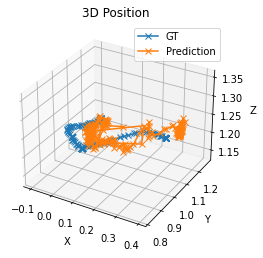

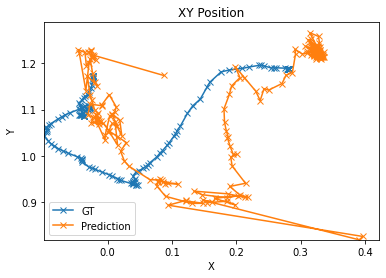

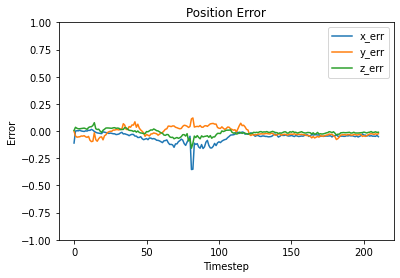

------ ROTATION -----
Positional Error Statistics: 
 MSE: 0.0005,
 std: 0.0001


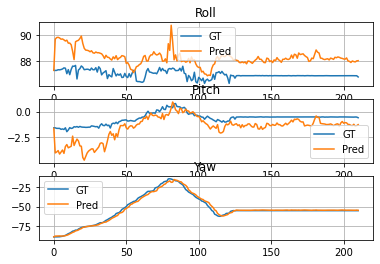

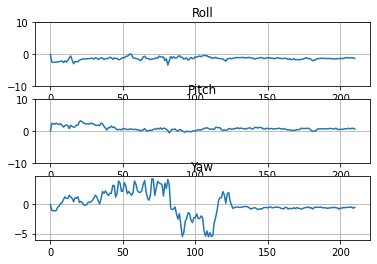

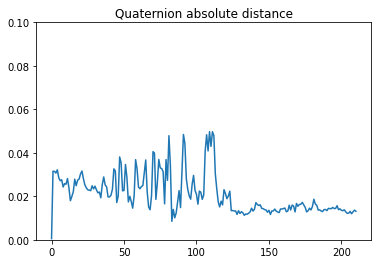

RESULTS WITH NN
found  202 Timestamps
------ POSITION -----
Positional Error Statistics: 
 MSE: 0.3693,
 std: 0.0817


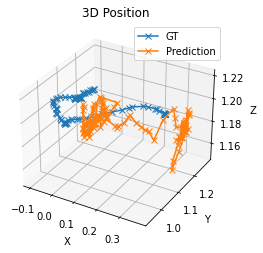

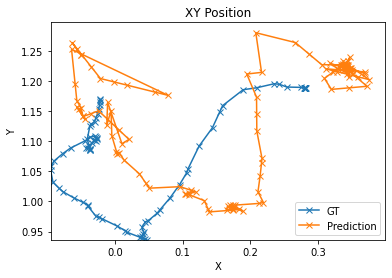

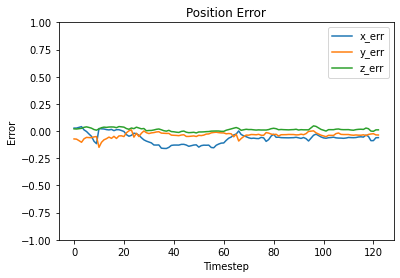

------ ROTATION -----
Positional Error Statistics: 
 MSE: 0.0002,
 std: 0.0001


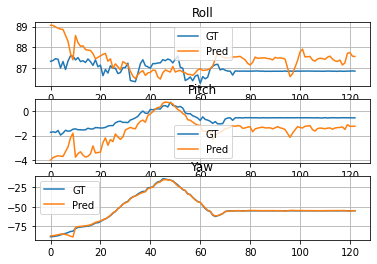

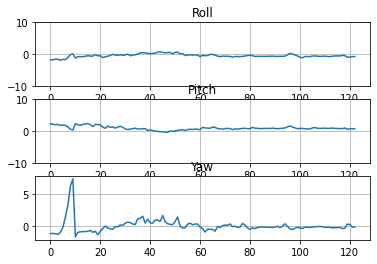

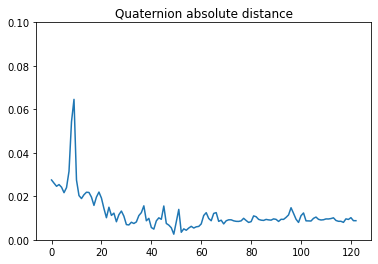

In [58]:
print("RESULTS FOR NO NN")
scoreTrajectory(gt_traj,prediction_traj, plot = True)
print("=============================================")
print("RESULTS WITH NN")
scoreTrajectory(gt_traj,prediction_traj_nn, plot = True)

# Traj 4

In [63]:
prediction_traj_nn = pd.read_csv('/home/rene/data/LEE/traj4_nn_pred.csv', index_col = False)
prediction_traj = pd.read_csv('/home/rene/data/LEE/traj4_no_nn.csv', index_col = False)
gt_traj =  pd.read_csv('/home/rene/data/LEE/gt4_traj_fixed_pose.csv', index_col = False)


RESULTS FOR NO NN
found  198 Timestamps
------ POSITION -----
Positional Error Statistics: 
 MSE: 20.6250,
 std: 1.7851


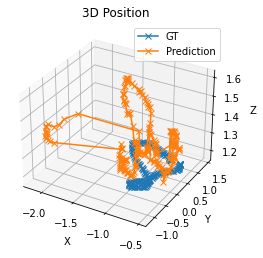

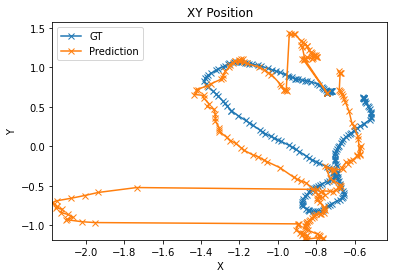

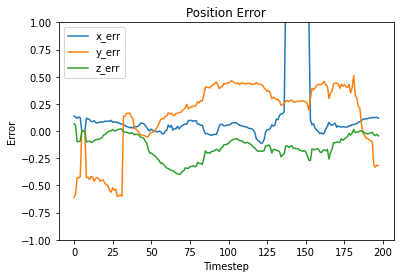

------ ROTATION -----
Positional Error Statistics: 
 MSE: 0.0019,
 std: 0.0003


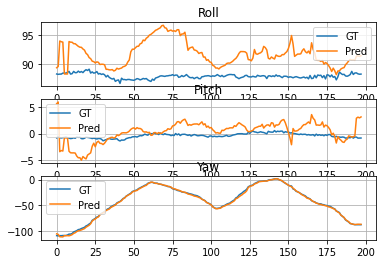

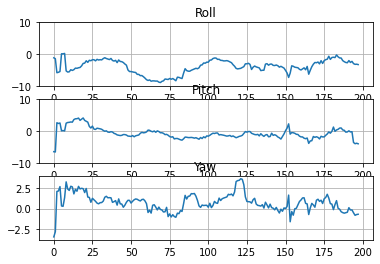

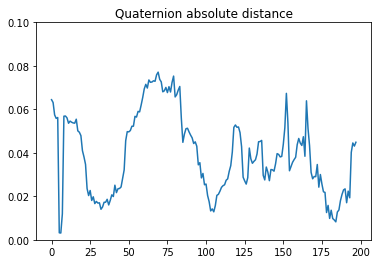

RESULTS WITH NN
found  197 Timestamps
------ POSITION -----
Positional Error Statistics: 
 MSE: 21.1454,
 std: 4.4820


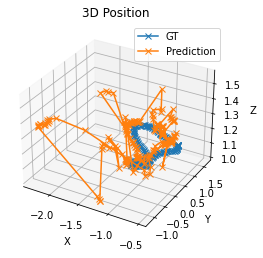

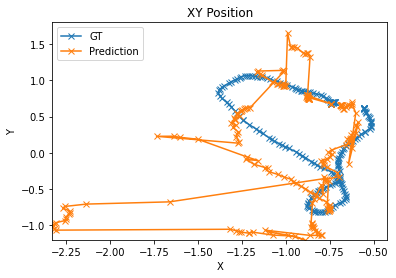

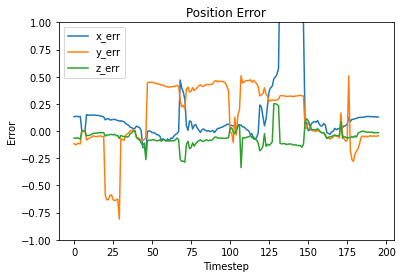

------ ROTATION -----
Positional Error Statistics: 
 MSE: 0.0012,
 std: 0.0002


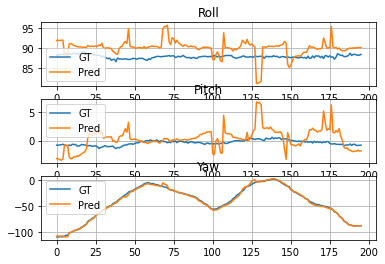

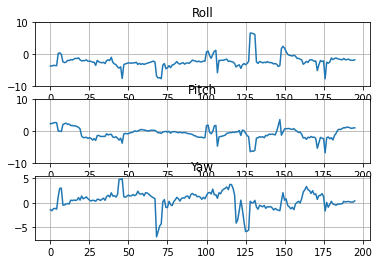

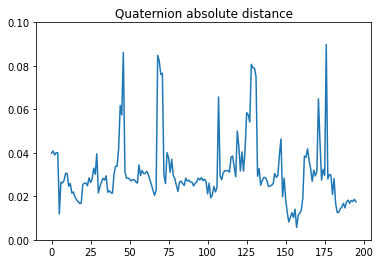

In [64]:
print("RESULTS FOR NO NN")
scoreTrajectory(gt_traj,prediction_traj, plot = True)
print("=============================================")
print("RESULTS WITH NN")
scoreTrajectory(gt_traj,prediction_traj_nn, plot = True)